In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

# Cross-Validation and Bias-Variance decomposition
## Cross-Validation
Implementing 4-fold cross-validation below:

In [2]:
from helpers import load_data

# load dataset
x, y = load_data()

In [3]:
def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)

In [4]:
from costs import compute_mse, compute_rmse
from ridge_regression import ridge_regression
from build_polynomial import build_poly

def cross_validation(y, x, k_indices, k, lambda_, degree, fct='rmse'):
    """return the loss of ridge regression."""
    # get k'th subgroup in test, others in train
    k_index = k_indices[k]
    y_test = y[k_index]
    x_test = x[k_index]

    mask = np.ones(x.shape[0], dtype=bool) # set all elements to True
    mask[k_index] = False                  # set test elements to False
    x_train=x[mask]                        # select only True elements (ie train elements)
    y_train=y[mask]
    
    # form data with polynomial degree
    tx_test = build_poly(x_test, degree)
    tx_train = build_poly(x_train, degree)

    # ridge regression and
    # calculate the loss for train and test data
    weight = ridge_regression(y_train, tx_train, lambda_)
    if fct=='mse':
        loss_tr = compute_mse(y_train, tx_train, weight)
        loss_te = compute_mse(y_test, tx_test, weight)
    else: #'rmse'
        loss_tr = compute_rmse(y_train, tx_train, weight)
        loss_te = compute_rmse(y_test, tx_test, weight)
    
    return loss_tr, loss_te

0.287655038865


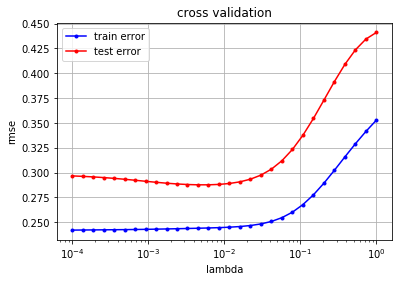

In [5]:
from plots import cross_validation_visualization

def cross_validation_demo():
    seed = 1
    degree = 7
    k_fold = 4
    lambdas = np.logspace(-4, 0, 30)
    # split data in k fold
    k_indices = build_k_indices(y, k_fold, seed)
    # define lists to store the loss of training data and test data
    rmse_tr = []
    rmse_te = []
    
    # cross validation
    for lambda_ in lambdas:
        rmse_tr_temp = 0
        rmse_te_temp = 0
        for k in range(k_fold):
            loss_tr_temp, loss_te_temp = cross_validation(y, x, k_indices, k, lambda_, degree)
            rmse_tr_temp += loss_tr_temp
            rmse_te_temp += loss_te_temp
        rmse_tr.append(rmse_tr_temp/k_fold)
        rmse_te.append(rmse_te_temp/k_fold)
    
    cross_validation_visualization(lambdas, rmse_tr, rmse_te)
    min_id = np.argmin(rmse_te)
    return rmse_te[min_id]

lambdaStar = cross_validation_demo()
print(lambdaStar)

8


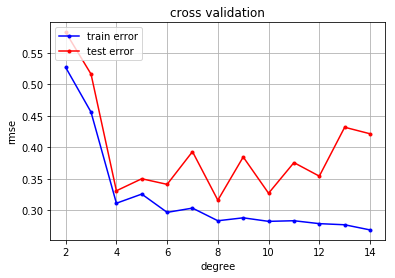

In [27]:
seed = 1
degrees = np.arange(2,15)
k_fold = 
# split data in k fold
k_indices = build_k_indices(y, k_fold, seed)
# define lists to store the loss of training data and test data
rmse_tr = []
rmse_te = []

# cross validation
all_rmse_tr = []
all_rmse_te = []
for degree in degrees:
    rmse_tr_temp = []
    rmse_te_temp = []
    for k in range(k_fold):
        loss_tr_temp, loss_te_temp = cross_validation(y, x, k_indices, k, lambdaStar, degree)
        rmse_tr_temp.append(loss_tr_temp)
        rmse_te_temp.append(loss_te_temp)
    all_rmse_tr.append(rmse_tr_temp)
    all_rmse_te.append(rmse_te_temp)
    rmse_tr.append(np.mean(rmse_tr_temp))
    rmse_te.append(np.mean(rmse_te_temp))

# visualisation
plt.plot(degrees, rmse_tr, marker=".", color='b', label='train error')
plt.plot(degrees, rmse_te, marker=".", color='r', label='test error')
plt.xlabel("degree")
plt.ylabel("rmse")
plt.title("cross validation")
plt.legend(loc=2)
plt.grid(True)
plt.savefig("cross_validation_degree")

bestDeg = degrees[np.argmin(rmse_te)]
print(bestDeg)

{'boxes': [<matplotlib.lines.Line2D at 0x7f389eac2f60>,
 'caps': [<matplotlib.lines.Line2D at 0x7f389ea96080>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f389eb19d68>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f389eb195c0>,
 'whiskers': [<matplotlib.lines.Line2D at 0x7f389eac2b70>,
  <matplotlib.lines.Line2D at 0x7f389e4cba90>]}

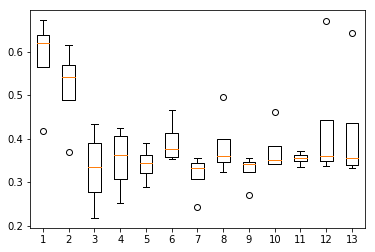

In [30]:
plt.boxplot(all_rmse_te)

{'boxes': [<matplotlib.lines.Line2D at 0x7f389e3d3940>,
 'caps': [<matplotlib.lines.Line2D at 0x7f389e3decc0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f389e36dbe0>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f389e3e6d30>,
 'whiskers': [<matplotlib.lines.Line2D at 0x7f389e3d3b00>,
  <matplotlib.lines.Line2D at 0x7f389e297f28>]}

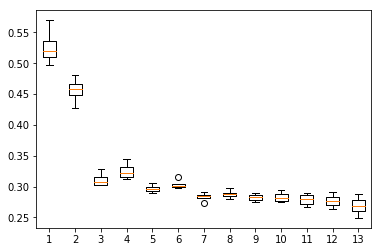

In [32]:
plt.boxplot(all_rmse_tr)

## Bias-Variance Decomposition
Visualize bias-variance trade-off by implementing the function `bias_variance_demo()` below:

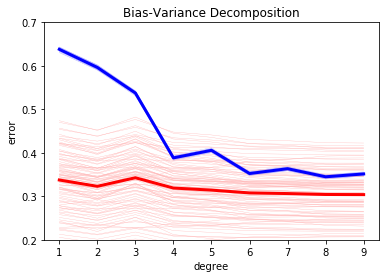

In [34]:
from least_squares import least_squares
from split_data import split_data
from plots import bias_variance_decomposition_visualization

def bias_variance_demo():
    """The entry."""
    # define parameters
    seeds = range(100)
    num_data = 10000
    ratio_train = 0.005
    degrees = range(1, 10)
    
    # define list to store the variable
    rmse_tr = np.empty((len(seeds), len(degrees)))
    rmse_te = np.empty((len(seeds), len(degrees)))
    
    for index_seed, seed in enumerate(seeds):
        np.random.seed(seed)
        x = np.linspace(0.1, 2 * np.pi, num_data)
        y = np.sin(x) + 0.3 * np.random.randn(num_data).T

        # split data with a specific seed
        y_train, x_train, y_test, x_test = split_data(x, y, ratio_train, seed)

        # bias_variance_decomposition
        for index_degree, degree in enumerate(degrees):
            loss_tr_temp, loss_te_temp = cross_validation(y_train, x_train, k_indices, k, lambdaStar, degree)
            rmse_tr[index_seed, index_degree] = loss_tr_temp ## TO MODIFY
            rmse_te[index_seed, index_degree] = loss_te_temp ## TO MODIFY
        
    bias_variance_decomposition_visualization(degrees, rmse_tr, rmse_te)

bias_variance_demo()